### Creates a tSNE Visualization of the given PorphyStruct Result data

In [3]:
import numpy as np
import pandas as pd
from data import constants
from mathutil import comp, percentage

In [4]:
df = pd.read_excel(r"C:\Users\jenso\PowerFolders\Forschung\CSD Data Mining\Results.xlsx")
df.fillna("", inplace=True)
dataset = df.loc[(df["Type"] == "Corrole") & (df["Class"] == "Corrole")]
dataset.reset_index(drop=True, inplace=True)
dataset = percentage.createPercData(dataset)
dataset = comp.createCompData(dataset)
dataset["dominant"] = dataset[constants.compColumns].idxmax(axis=1)


c:\Users\jenso\Documents\Projects\porphystruct-scripts\mathutil\percentage.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + "%"] = df[col].abs()/sum
c:\Users\jenso\Documents\Projects\porphystruct-scripts\mathutil\comp.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + " comp"] = __compValue(df[col+"1"], df[col + "2"])
C:\Users\jenso\AppData\Local\Temp/ipykernel_23624/4246290992.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [5]:
len(dataset)

863

### Prepare sklearn stuff

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import  SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [7]:
preprocess = ColumnTransformer(
    transformers = [
        ("prepocess_ext", Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                ("scaler", StandardScaler())
            ]
        ), constants.percColumns)
    ], sparse_threshold=0)

### Do TSNE Computation

In [8]:
tsne = TSNE(n_components=2, random_state=69420, perplexity=50, n_iter=5000)
df_mapping = pd.DataFrame(tsne.fit_transform(preprocess.fit_transform(dataset)), columns=["x", "y"])


### Add Columns for Viz

In [9]:
df_mapping["M"] = dataset["Metal"]
df_mapping["Doop"] = dataset["DoopExp"]
df_mapping["Group"] = dataset["Group"].astype(str)
df_mapping["dominant"] = dataset["dominant"]
df_mapping["Cu"] = dataset["Metal"] == "Cu"
df_mapping["H"] = dataset["Metal"] == "H"
df_mapping["Class"] = dataset["Class"]



### Plot Stuff

In [10]:
! pip install plotnine
! pip install natsort
! pip install -U kaleido
! pip install plotly

import plotly.express as px
from natsort import index_natsorted
import plotly.express as px
from plotnine import *
import plotly.io as pio
import plotly
plotly.__version__ #5.6.0
import kaleido #required
kaleido.__version__ #0.2.1

'0.2.1'

In [11]:
df_mapping.sort_values(by="Group", key=lambda x: np.argsort(index_natsorted(df_mapping["Group"])), inplace=True)

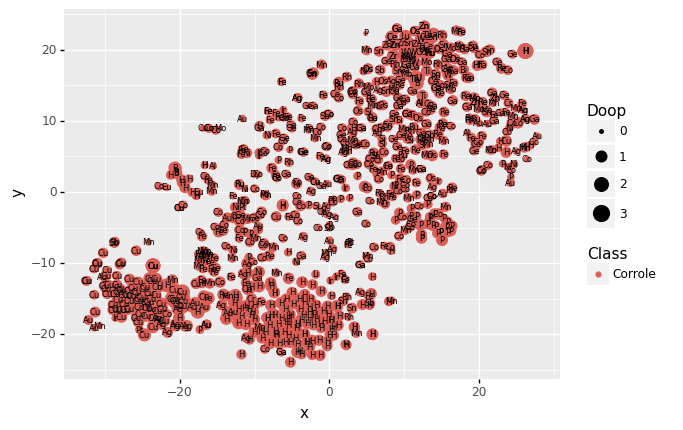

<ggplot: (145770496997)>

In [12]:
ggplot(df_mapping,aes(x="x", y="y", label="M")) + geom_point(aes(size="Doop", colour="Class")) + geom_text(size=6)

In [13]:
metrix = ["Cu", "H", "dominant", "Group", "Class"]
for k in metrix:
    fig = px.scatter(df_mapping, x="x", y="y", color=k, size="Doop", text="M")
    fig.update_traces(textfont_size=8)
    pio.write_image(fig, f"out/tsne_{k}.png", scale=15)
